# Import Data

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d thesighsrikar/concrete-crack-images-for-classification

 94% 220M/234M [00:01<00:00, 130MB/s]
100% 234M/234M [00:01<00:00, 138MB/s]


In [ ]:
! unzip -u "/content/concrete-crack-images-for-classification" -d "/tmp/"

# Membagi Data

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/tmp/Concrete', output="/tmp/base_path", seed=20, ratio=(0.8,0.2), group_prefix=None)

Copying files: 40000 files [00:06, 5763.59 files/s]


# Melakukan Preprocessing

In [ ]:
import os

In [ ]:
base_dir = '/tmp/base_path'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
os.listdir(train_dir)

['Positive', 'Negative']

In [ ]:
os.listdir(validation_dir)

['Positive', 'Negative']

In [ ]:
len(os.listdir(validation_dir))

2

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
  
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    vertical_flip=True,
                    )
  
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        batch_size=64,
        class_mode='binary',
        target_size=(100, 100))
  
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        batch_size=64,
        class_mode='binary',
        target_size=(100, 100))

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


# Masuk ke ML 

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nAkurasi telah mencapai >90%!")
callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 10, 10, 128)     

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
hist = model.fit(
        train_generator,
        epochs=100,#Training longer could yield better results
        batch_size=1024,
        validation_data=validation_generator,
        steps_per_epoch=25,
        callbacks=[callbacks])

Epoch 1/100
25/25 [==============================] - 72s 3s/step - loss: 0.4405 - accuracy: 0.7875 - val_loss: 0.1483 - val_accuracy: 0.9452
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9581
Akurasi telah mencapai >90%!
25/25 [==============================] - 70s 3s/step - loss: 0.1315 - accuracy: 0.9581 - val_loss: 0.0905 - val_accuracy: 0.9701


# Membuat Plot

In [ ]:
import matplotlib.pyplot as plt

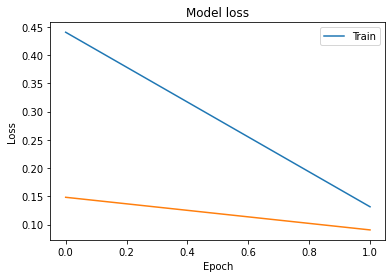

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

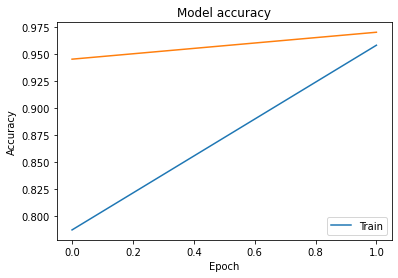

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model("/content/mymodel")
tflite_model = converter.convert()
  
tflite_model_file = pathlib.Path('crackStructure.tflite')
tflite_model_file.write_bytes(tflite_model)

5166540